In [1]:
import numpy as np
import torch
import random
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 数据预处理
dtype = torch.FloatTensor

mem = Memory("./mycache")
@mem.cache
def get_data(filename):
    data = load_svmlight_file(filename)
    return data[0], data[1]

x_train, y_train = get_data("a9a")
x_test, y_test = get_data("a9a.t")

# 32561 x 123
x_train = x_train.toarray()
x_train = torch.from_numpy(x_train).type(dtype)

bias = torch.ones(x_train.size(0), 1)
x_train = torch.cat((x_train, bias), 1)

# 32561 x 1
y_train = np.array(y_train).reshape(-1,1)
y_train = torch.from_numpy(y_train).type(dtype)

# 16281 x 122
x_test = x_test.toarray()
x_test = torch.from_numpy(x_test).type(dtype)

# 16281 x 1
y_test = np.array(y_test).reshape(-1,1)
y_test = torch.from_numpy(y_test).type(dtype)

dim = max(x_train.size(1)-1, x_test.size(1))
x_test = torch.cat((x_test, torch.zeros(x_test.size(0), dim - x_test.size(1))), 1) # 补0

bias = torch.ones(x_test.size(0), 1)
x_test = torch.cat((x_test, bias), 1)

In [3]:
class SVM(object):
    def __init__(self):
        self.W = []        
        # 模型参数全零初始化
        self.W.append(torch.zeros(1, x_train.size(1)))

    def loss(self, x, y, reg):
        hingeLoss = 1 - torch.mul(y, torch.mm(x, self.W[-1].t()))
        hingeLoss[hingeLoss < 0] = 0
        # hingeLoss = torch.max(0, 1 - torch.mul(y, torch.mm(x, self.W[-1].t())))
        loss = 0.5 * torch.sum(self.W[-1]**2) + reg * torch.sum(hingeLoss) / x.size(0)
        return loss
        
    def grad(self, W, x, y, reg):
        margin = 1 - torch.mul(y, torch.mm(x, W.t()))
        minus_y = -y
        minus_y[margin < 0] = 0
        dW = W + reg * torch.mm(x.t(), minus_y).t()
        # The first iterm have not effection on 'b'
        dW[0][-1] -= W[0][-1]
        return dW
   
    def predict(self, x, threshold=0.0):
        score = torch.mm(x, self.W[-1].t())
        y_pred = torch.ones((x.size(0), 1))
        y_pred[score < threshold] = -1
        return y_pred
    
    def train(self, optimizer, train_params,optimizer_params): 
        # track the loss history
        loss_validation_history = []
        iteras = []
        
        # track the best accuracy and loss respectly
        best_acc = 0.0
        best_it = 0
        lowest_loss  = 1e9
        lowest_it = 0
        
        # get the train parameters
        num_iters = train_params.setdefault('num_iters', 100)
        batch_size = train_params.setdefault('batch_size', 10)
        threshold = train_params.setdefault('threshold', 0.0)
        verbose = train_params.setdefault('verbose', True)
        reg = train_params.setdefault('reg', 10)
        
        for it in range(num_iters):
            # choose random batch examples
            batch_mask = np.random.choice(x_train.size(0), batch_size)
            batch_mask = torch.from_numpy(batch_mask)
            x_batch = x_train[batch_mask]
            y_batch = y_train[batch_mask]
            
            grad = lambda W: self.grad(W, x_batch, y_batch, reg)
            
            # use optimizer to upate the weight
            new_W, optimizer_params = optimizer(self.W[-1], grad, optimizer_params)
            self.W.append(new_W)
            
            # calculate the loss on validataion data
            loss_vali = self.loss(x_test, y_test, reg)
            loss_validation_history.append(loss_vali)
            
            # Calculate the accuracy on validation data
            y_pred = self.predict(x_test, threshold)
            acc = torch.mean((y_pred == y_test).type(dtype))
            
            # Update the best result
            if best_acc < acc:
                best_acc = acc
                best_it = it + 1
            if lowest_loss > loss_vali:
                lowest_loss = loss_vali
                lowest_it = it + 1
            if verbose:
                print('iteration %d / %d: validation_loss %f, accuracy %f' % (it+1, num_iters , loss_vali, acc))
        print("Best result:  iteration %d,  accuracy %f" %(best_it, best_acc))
        print("Lowest loss:  iteration %d,  loss %f" %(lowest_it, lowest_loss))
        return loss_validation_history

Best result:  iteration 1484,  accuracy 0.836804
Lowest loss:  iteration 796,  loss 4.517127


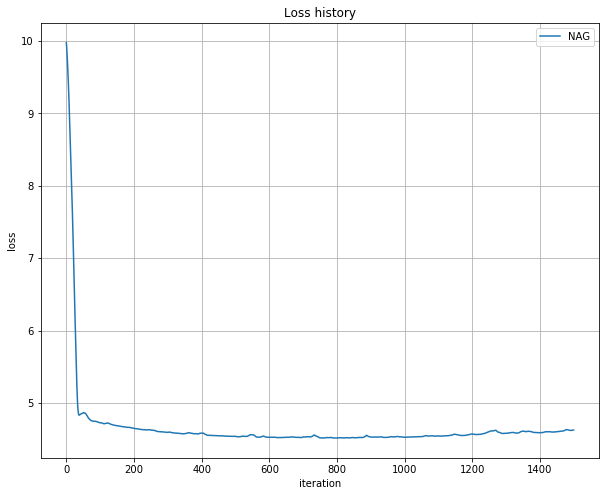

In [4]:
def NAG(W, grad, optimizer_params):
    v = optimizer_params.setdefault("v", torch.zeros(W.size()))
    mu = optimizer_params.setdefault("mu", 0.9)
    lr = optimizer_params.setdefault("lr", 1e-4)
    
    # to calculate ahead grad
    dW = grad(W + mu*v)
            
    # calculate the momentum
    v = mu*v - lr * dW
    
    # update the self.W
    next_W = W + v
    
    # updata the params
    optimizer_params['v'] = v
    return next_W, optimizer_params

model = SVM()
train_params = {
    'num_iters': 1500,
    'batch_size': 10,
    'threshold': 0.0,
    'verbose': False,
    'reg': 10
}
optimizer_params = {
    'mu': 0.9,
    'lr': 1e-5
}

loss_vali_NAG = model.train(NAG, train_params, optimizer_params)
# plot the loss history
plt.rcParams['figure.figsize'] = (10.0, 8.0) #set default size
plt.plot(loss_vali_NAG,label = "NAG")
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss history')
plt.legend(loc = 'best')
plt.grid()
plt.show()

Best result:  iteration 1500,  accuracy 0.830416
Lowest loss:  iteration 857,  loss 4.589961


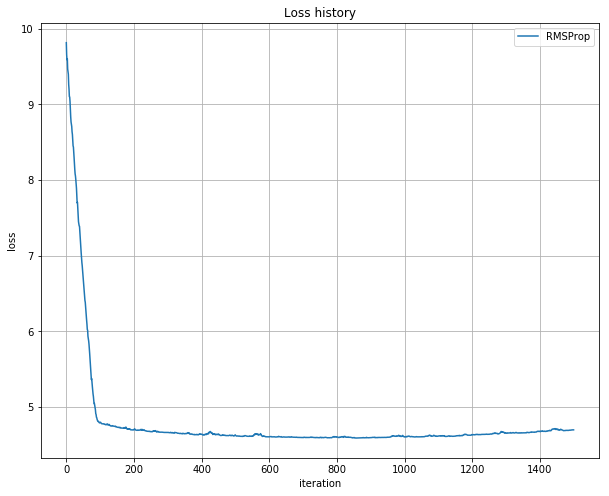

In [5]:
def RMSProp(W, grad, optimizer_params):
    lr = optimizer_params.setdefault("lr", 1e-4)
    decay_rate = optimizer_params.setdefault("decay_rate", 0.9)
    cache = optimizer_params.setdefault("cache", torch.zeros(W.size()))
    eps = optimizer_params.setdefault("eps", 1e-7)
    
    # to calculate ahead grad
    dW = grad(W)
            
    # calculate the squared grad for every element
    cache = decay_rate*cache + (1 - decay_rate) * dW**2
    
    # update the self.W
    next_W = W - lr * dW / (torch.sqrt(cache) + eps)
    
    # updata the params
    optimizer_params['cache'] = cache
    return next_W, optimizer_params

model = SVM()
train_params = {
    'num_iters': 1500,
    'batch_size': 10,
    'threshold': 0.0,
    'verbose': False,
    'reg':10
}
optimizer_params = {
    'lr': 1e-3,
    'decay_rate':0.9
}

loss_vali_RMSProp = model.train(RMSProp, train_params, optimizer_params)

# plot the loss history
plt.plot(loss_vali_RMSProp,label = "RMSProp")
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss history')
plt.legend(loc = 'best')
plt.grid()
plt.show()

Best result:  iteration 1244,  accuracy 0.841656
Lowest loss:  iteration 816,  loss 4.548954


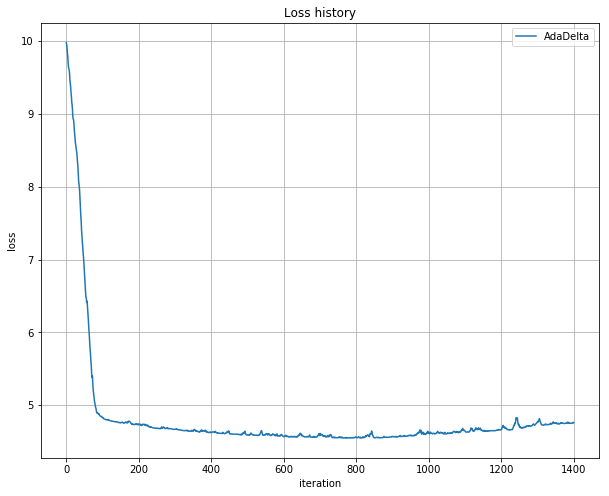

In [6]:
def AdaDelta(W, grad, optimizer_params):
    decay_rate = optimizer_params.setdefault("decay_rate", 0.9)
    cache_grad = optimizer_params.setdefault("cache_grad", torch.zeros(W.size()))
    cache_step = optimizer_params.setdefault("cache_step", torch.zeros(W.size()))
    eps = optimizer_params.setdefault("eps", 1e-6)
    
    # to calculate ahead grad
    dW = grad(W)
            
    # keeps track of per-parameter sum of squared gradients.
    cache_grad = decay_rate*cache_grad + (1 - decay_rate) * (dW**2)
    
    # calculate the step based on cache_step and cache_grad
    step = - (torch.sqrt(cache_step) + eps) * dW / (torch.sqrt(cache_grad) + eps)
    
    # update the self.W
    next_W = W + step
    
    # keeps track of step
    cache_step = decay_rate*cache_step + (1 - decay_rate) * (step**2)    
    
    # updata the params
    optimizer_params['cache_step'] = cache_step
    optimizer_params['cache_grad'] = cache_grad
    
    return next_W, optimizer_params

model = SVM()
train_params = {
    'num_iters': 1400,
    'batch_size': 10,
    'threshold': 0.0,
    'verbose': False,
    'reg': 10
}
optimizer_params = {
    'eps': 1e-4,
    'decay_rate': 0.95
}

loss_vali_AdaDelta = model.train(AdaDelta, train_params, optimizer_params)
# plot the loss history15
plt.plot(loss_vali_AdaDelta,label = "AdaDelta")
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss history')
plt.legend(loc = 'best')
plt.grid()
plt.show()

Best result:  iteration 1496,  accuracy 0.830232
Lowest loss:  iteration 704,  loss 4.630966


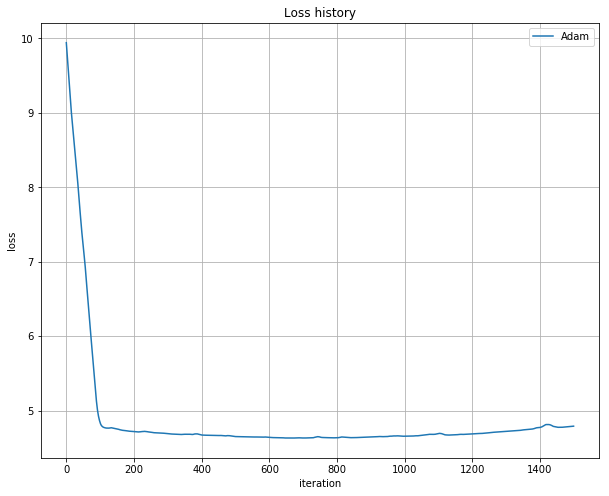

In [7]:
def Adam(W, grad, optimizer_params):
    lr = optimizer_params.setdefault("lr", 1e-4)
    beta1 = optimizer_params.setdefault("beta1", 0.9)
    beta2 = optimizer_params.setdefault("beta2", 0.999)
    moment = optimizer_params.setdefault("moment", torch.zeros(W.size()))
    cache_grad = optimizer_params.setdefault("cache_grad", torch.zeros(W.size()))
    it = optimizer_params.setdefault("it",1)
    eps = optimizer_params.setdefault("eps", 1e-6)
    
    # to calculate ahead grad
    dW = grad(W)
            
    # keep the moment
    moment = beta1*moment + (1-beta1)*dW

    moment_scale = moment / (1 - beta1**it)

    # keep the squared gradients
    cache_grad = beta2 * cache_grad + (1 - beta2) * (dW ** 2)
    cache_grad_scale = cache_grad / (1- beta2**it) # 

    # update self.W
    next_W = W - lr * moment_scale / (torch.sqrt(cache_grad_scale) + eps)    
    
    # updata the params
    optimizer_params['moment'] = moment
    optimizer_params['cache_grad'] = cache_grad
    optimizer_params['it'] = it + 1
                                     
    return next_W, optimizer_params

model = SVM()
train_params = {
    'num_iters': 1500,
    'batch_size': 10,
    'threshold': 0.0,
    'verbose': False,
    'reg': 10
}
optimizer_params = {
    'lr': 1e-3,
    'beta1': 0.9,
    'beta2': 0.999,
}

loss_vali_Adam = model.train(Adam, train_params, optimizer_params)
# plot the loss history
plt.plot(loss_vali_Adam,label = "Adam")
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss history')
plt.legend(loc = 'best')
plt.grid()
plt.show()

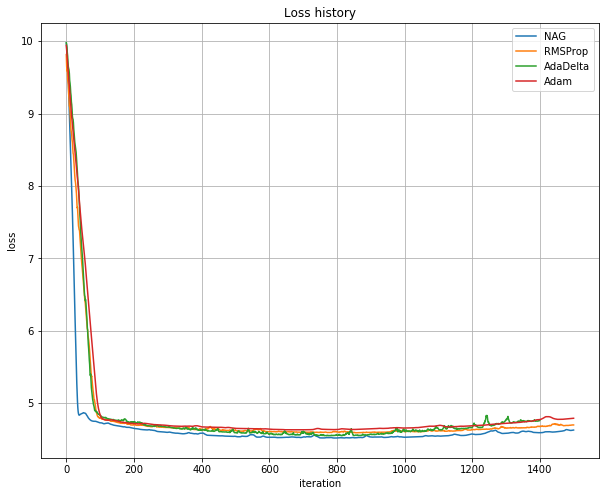

In [8]:
# plot the loss history
plt.plot(loss_vali_NAG,label = "NAG")
plt.plot(loss_vali_RMSProp,label = "RMSProp")
plt.plot(loss_vali_AdaDelta,label = "AdaDelta")
plt.plot(loss_vali_Adam,label = "Adam")
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss history')
plt.legend(loc = 'best')
plt.grid()
plt.show()